In [1]:
from tqdm import tqdm
import pandas as pd
import time
import cv2
import os

from pathlib import Path
from pandas import DataFrame
from typing import Callable

from common.deblurrers import Deblurrer
from common.config import BLUR_PARAM_RANGES, TEST_BLURRED_DIR
from common.blurrer import gen_box_kernel, gen_gaussian_kernel, gen_motion_kernel

def measure_time(cb: Callable, *args, **kwargs):
    start_time = time.perf_counter()
    res = cb(*args, **kwargs)
    end_time = time.perf_counter()
    return res, (end_time - start_time)

def deblur(
        deblurrer: Deblurrer,
        input_path: Path, 
        output_path: Path, 
        kernel_df: DataFrame = None,
        gen_kernel: Callable = None,
        sample: int = None,
        description: str = ""
    ):
    os.makedirs(output_path, exist_ok=True)

    images_paths = [input_path]
    if not input_path.is_file():
        images_paths = sorted(list(input_path.glob("*.png")))
    if sample and sample >= len(images_paths):
        raise ValueError("sample cannot be greater than number of images")
    if sample:
        images_paths = images_paths[:sample]

    proc_times = {}
    for img_path in tqdm(images_paths, desc=description):
        image = cv2.imread(img_path)
        if image is None:
            print("Could not read the image")
            continue

        img_name = img_path.name
        img_key = img_name.replace('.png', '')

        if kernel_df is not None:
            if not gen_kernel:
                raise ValueError("gen_kernel must be specified when using kernel_df")
            
            # unpack arguments from kernel_df without "key" column
            args = kernel_df.loc[kernel_df["key"] == img_key].drop(columns="key").to_dict(orient="records")[0]
            kernel = gen_kernel(**args)
            deblurred, proc_times[img_key] = measure_time(deblurrer.deblur, **{"image": image, "kernel": kernel})
        else:
            deblurred, proc_times[img_key] = measure_time(deblurrer.deblur, **{"image": image})

        cv2.imwrite(output_path / img_name, deblurred)

    return proc_times

def gen_dataset(
        deblurrer: Deblurrer,
        output_path: Path,
        deblurrer_dataset_path: Path = None,
        input_path: Path = TEST_BLURRED_DIR,
        kernel_dataset_path: Path = None,
        sample: int = None,
    ):

    deblurrer_df = None
    if deblurrer_dataset_path is not None:
        deblurrer_df = pd.read_parquet(deblurrer_dataset_path) if deblurrer_dataset_path.exists() else pd.DataFrame()

    df = None
    if kernel_dataset_path:
        df = pd.read_parquet(kernel_dataset_path)

    for blur_type, params in BLUR_PARAM_RANGES.items():
        kernel_df = None
        cb = None
        if df is not None:
            # convert params to column names
            params = [f"{blur_type}_{el}" for el in params.keys()]

            # select key and blur_type parameters, then rename them to correspond to gen_*_kernel arguments 
            kernel_df = df[["key", *params]].rename(
                columns={col: col.replace(f"{blur_type}_", "") for col in params}
            )

            match blur_type:
                case "box":
                    cb = gen_box_kernel
                case "gaussian":
                    cb = gen_gaussian_kernel
                case "motion":
                    cb = gen_motion_kernel

        proc_times = deblur(
            deblurrer=deblurrer,
            input_path=input_path / blur_type,
            output_path=output_path / blur_type,
            kernel_df=kernel_df,
            gen_kernel=cb,
            sample=sample,
            description=f"Deblur: {blur_type:<8}\t",
        )

        if deblurrer_df is not None:
            if "key" not in deblurrer_df.columns:
                deblurrer_df["key"] = list(proc_times.keys())
            deblurrer_df[f"proctime_{blur_type}"] = deblurrer_df["key"].map(proc_times)

    if deblurrer_df is not None:
        deblurrer_df.to_parquet(deblurrer_dataset_path)

# Generation of the deblurred/


## Pseudo Inverse


In [2]:
from common.deblurrers import PseudoInverseDeblurrer
from common.config import TEST_DEBLURRED_OFFICIAL_DIR, PSEUDOINVERSE_NOKERNEL_DATASET

pseudo_deblurrer = PseudoInverseDeblurrer()

# no_kernel generation
gen_dataset(
    deblurrer=pseudo_deblurrer,
    output_path=TEST_DEBLURRED_OFFICIAL_DIR / f"{pseudo_deblurrer.get_name()}_nokernel",
    deblurrer_dataset_path=PSEUDOINVERSE_NOKERNEL_DATASET,
)

Deblur: motion  	: 100%|██████████| 950/950 [13:07<00:00,  1.21it/s]


In [4]:
from common.deblurrers import PseudoInverseDeblurrer
from common.config import TEST_DEBLURRED_OFFICIAL_DIR, IDPA_DATASET, PSEUDOINVERSE_WKERNEL_DATASET

pseudo_deblurrer = PseudoInverseDeblurrer()

# w_kernel generation
gen_dataset(
    deblurrer=pseudo_deblurrer,
    output_path=TEST_DEBLURRED_OFFICIAL_DIR / f"{pseudo_deblurrer.get_name()}_wkernel",
    deblurrer_dataset_path=PSEUDOINVERSE_WKERNEL_DATASET,
    kernel_dataset_path=IDPA_DATASET,
)

Deblur: motion  	: 100%|██████████| 950/950 [12:31<00:00,  1.26it/s]


## Wiener


In [2]:
from common.deblurrers import WienerDeblurrer
from common.config import TEST_DEBLURRED_OFFICIAL_DIR, WIENER_NOKERNEL_DATASET

wiener_deblurrer = WienerDeblurrer()

# no_kernel generation
gen_dataset(
    deblurrer=wiener_deblurrer,
    output_path=TEST_DEBLURRED_OFFICIAL_DIR / f"{wiener_deblurrer.get_name()}_nokernel",
    deblurrer_dataset_path=WIENER_NOKERNEL_DATASET,
)

Deblur: motion  	: 100%|██████████| 950/950 [12:12<00:00,  1.30it/s]


In [3]:
from common.deblurrers import WienerDeblurrer
from common.config import TEST_DEBLURRED_OFFICIAL_DIR, IDPA_DATASET, WIENER_WKERNEL_DATASET

wiener_deblurrer = WienerDeblurrer()

# w_kernel generation
gen_dataset(
    deblurrer=wiener_deblurrer,
    output_path=TEST_DEBLURRED_OFFICIAL_DIR / f"{wiener_deblurrer.get_name()}_wkernel",
    deblurrer_dataset_path=WIENER_WKERNEL_DATASET,
    kernel_dataset_path=IDPA_DATASET,
)

Deblur: motion  	: 100%|██████████| 950/950 [11:10<00:00,  1.42it/s]


## DeblurGANv2


In [2]:
from common.deblurrers import DeblurGANv2Deblurrer
from common.config import OFFICIAL_DEBLURGANV2_WEIGHTS, TEST_DEBLURRED_OFFICIAL_DIR, DEBLURGANV2_DATASET

deblurganv2_deblurrer = DeblurGANv2Deblurrer(
    weights_path=OFFICIAL_DEBLURGANV2_WEIGHTS
)

gen_dataset(
    deblurrer=deblurganv2_deblurrer,
    output_path=TEST_DEBLURRED_OFFICIAL_DIR / deblurganv2_deblurrer.get_name(),
    deblurrer_dataset_path=DEBLURGANV2_DATASET,
)

Deblur: motion  	: 100%|██████████| 950/950 [06:03<00:00,  2.61it/s]  


## MPRNet


In [ ]:
from common.deblurrers import MPRNetDeblurrer
from common.config import OFFICIAL_MPRNET_WEIGHTS, TEST_DEBLURRED_OFFICIAL_DIR, MPRNET_DATASET

mprnet_deblurrer = MPRNetDeblurrer(
    weights_path=OFFICIAL_MPRNET_WEIGHTS
)

gen_dataset(
    deblurrer=mprnet_deblurrer,
    output_path=TEST_DEBLURRED_OFFICIAL_DIR / mprnet_deblurrer.get_name(),
    deblurrer_dataset_path=MPRNET_DATASET,
)

# Demonstration on one single image


In [2]:
import matplotlib.pyplot as plt
import cv2
import os

from common.config import TEST_BLURRED_DIR, BLUR_TYPES, TEST_ORIGINAL_DIR

# types
from pathlib import Path
from common.deblurrers import Deblurrer, ClassicalDeblurrer

def cp_img(source, destination):
    os.makedirs(destination.parents[0], exist_ok=True)
    img = cv2.imread(source)
    cv2.imwrite(destination, img)

def crop(img, cropx=256, cropy=256, percent_x=0.5, percent_y=0.5):
        """
        Crop the image to (cropx, cropy) centered at (percent_x, percent_y) of the image dimensions.
        percent_x and percent_y should be between 0.0 and 1.0.
        """
        y, x = img.shape[:2]
        centerx = int(x * percent_x)
        centery = int(y * percent_y)
        startx = max(centerx - cropx // 2, 0)
        starty = max(centery - cropy // 2, 0)
        endx = min(startx + cropx, x)
        endy = min(starty + cropy, y)
        return img[starty:endy, startx:endx]

def demo_deblur(
    deblurrer: Deblurrer,
    output_path: Path,
    img_name: str,
    original_path: Path = TEST_ORIGINAL_DIR / "00000",
    blurred_path: Path = TEST_BLURRED_DIR,
    kernel_dataset_path: Path = None,
    is_crop: bool = True
):
    deblurrer_name = deblurrer.get_name()

    # copy original image to output_path
    cp_img(
        source=original_path / img_name,
        destination=output_path / img_name
    )

    # copy blurred images to output_path
    for blur_type in BLUR_TYPES:
        cp_img(
            source=blurred_path / blur_type / img_name, 
            destination=output_path / "blurred" / blur_type / img_name
        )

    if isinstance(deblurrer, ClassicalDeblurrer):
        gen_dataset(
            deblurrer=deblurrer,
            input_path=output_path / "blurred",
            output_path=output_path / deblurrer.get_name() / "wkernel",
            kernel_dataset_path=kernel_dataset_path,
        )

    gen_dataset(
        deblurrer=deblurrer,
        input_path=output_path / "blurred",
        output_path=output_path / deblurrer.get_name() / "nokernel",
    )

    # show images
    for blur_type in BLUR_TYPES:
        original = cv2.imread(output_path / img_name)
        blurred = cv2.imread(output_path / "blurred" / blur_type / img_name)
        deblurred_nokernel = cv2.imread(output_path / deblurrer.get_name() / "nokernel" / blur_type / img_name)
        deblurred_wkernel = None
        if (output_path / deblurrer.get_name() / "wkernel").exists():
            deblurred_wkernel = cv2.imread(output_path / deblurrer.get_name() / "wkernel" / blur_type / img_name)

        images = [
            {
                "title": "Original",
                "image": original
            }
        ]

        if deblurred_wkernel is not None:
            images.append(
                {
                    "title": f"{deblurrer_name} wkernel",
                    "image": deblurred_wkernel
                }
            )

        images += [
            {
                "title": (f"{deblurrer_name} nokernel" if deblurred_wkernel is not None else deblurrer_name),
                "image": deblurred_nokernel
            },
            {
                "title": f"Blurred ({blur_type})",
                "image": blurred
            }
        ]

        for el in images:
            el["image"] = cv2.cvtColor(el["image"], cv2.COLOR_BGR2RGB)

            if is_crop:
                el["image"] = crop(el["image"])

        _, axes = plt.subplots(1, len(images), figsize=(15, 5))

        for i, el in enumerate(images):
            axes[i].imshow(el["image"])
            axes[i].set_title(el["title"])

        for ax in axes:
            ax.axis('off')
        plt.show()

Deblur: motion  	: 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


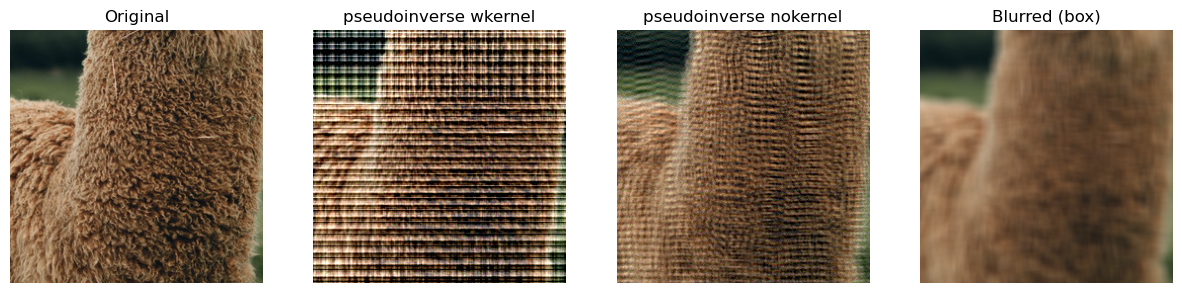

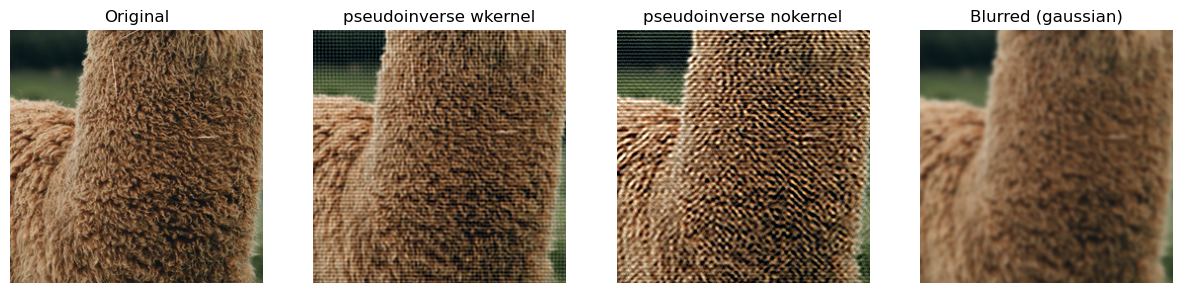

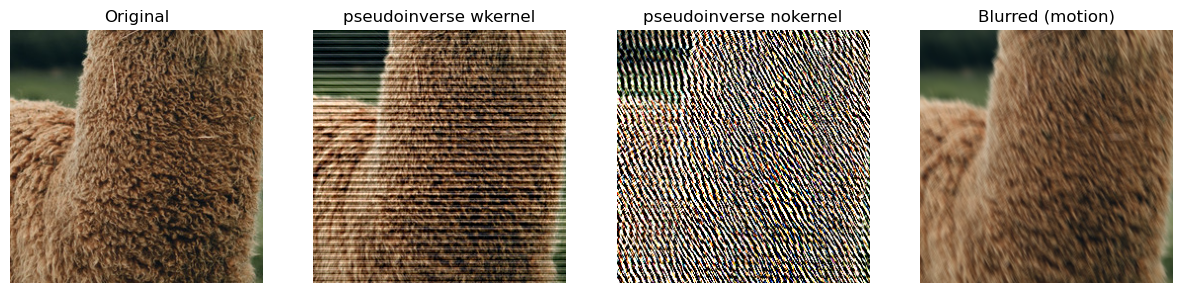

In [3]:
from common.deblurrers import PseudoInverseDeblurrer
from common.config import IDPA_DIR, IDPA_DATASET

pseudo_deblurrer = PseudoInverseDeblurrer()
demo_deblur(
    deblurrer=pseudo_deblurrer,
    output_path=IDPA_DIR / ".imgs",
    img_name="000000845.png",
    kernel_dataset_path=IDPA_DATASET,
    is_crop=True
)

Deblur: box     	:   0%|          | 0/1 [00:00<?, ?it/s]

Deblur: motion  	: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


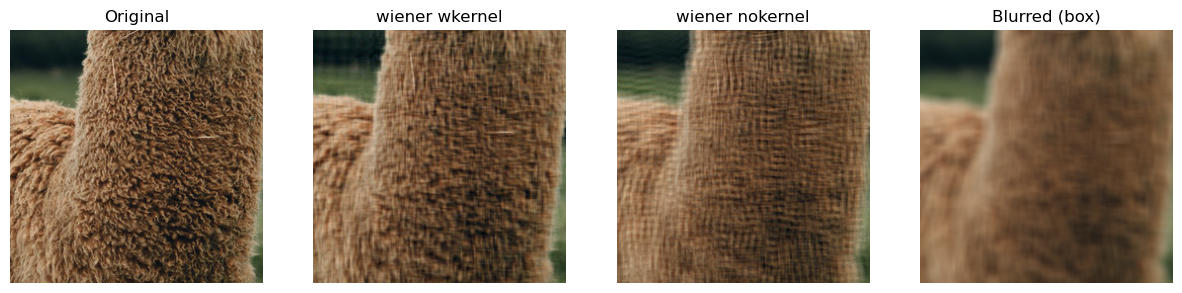

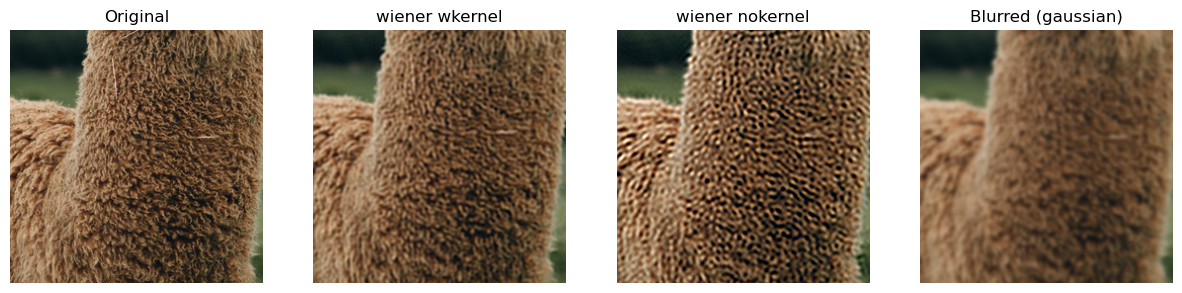

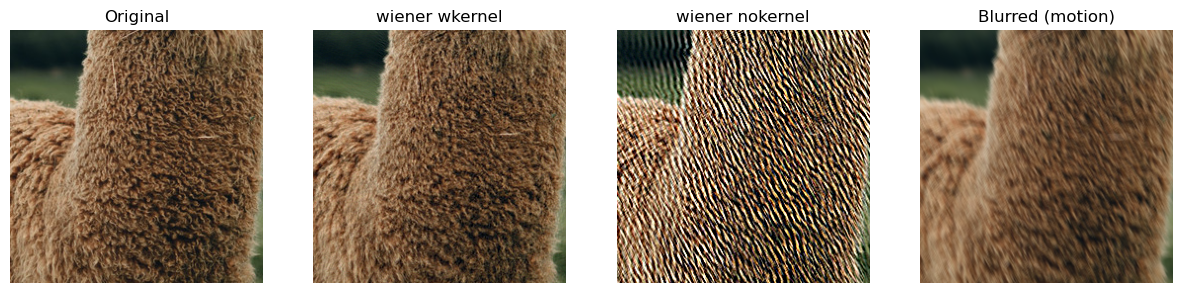

In [4]:
from common.deblurrers import WienerDeblurrer
from common.config import IDPA_DIR, IDPA_DATASET

wiener_deblurrer = WienerDeblurrer()
demo_deblur(
    deblurrer=wiener_deblurrer,
    output_path=IDPA_DIR / ".imgs",
    img_name="000000845.png",
    kernel_dataset_path=IDPA_DATASET,
    is_crop=True
)

Deblur: motion  	: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


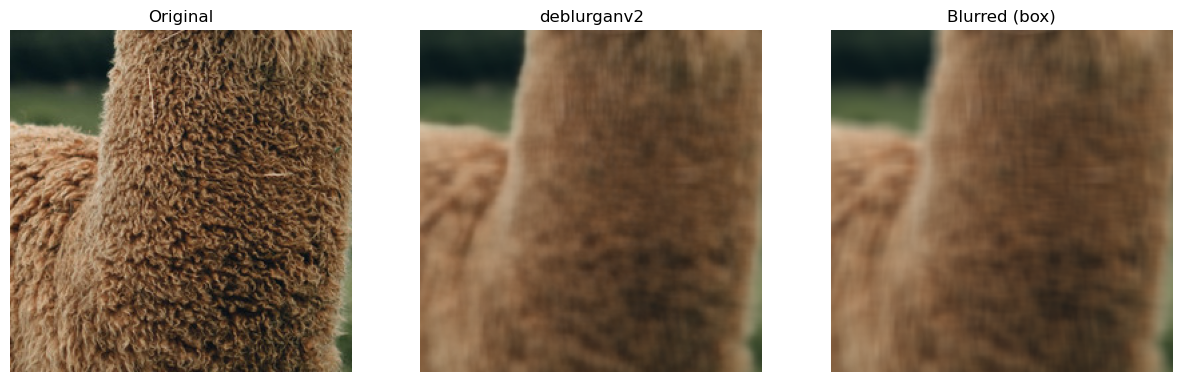

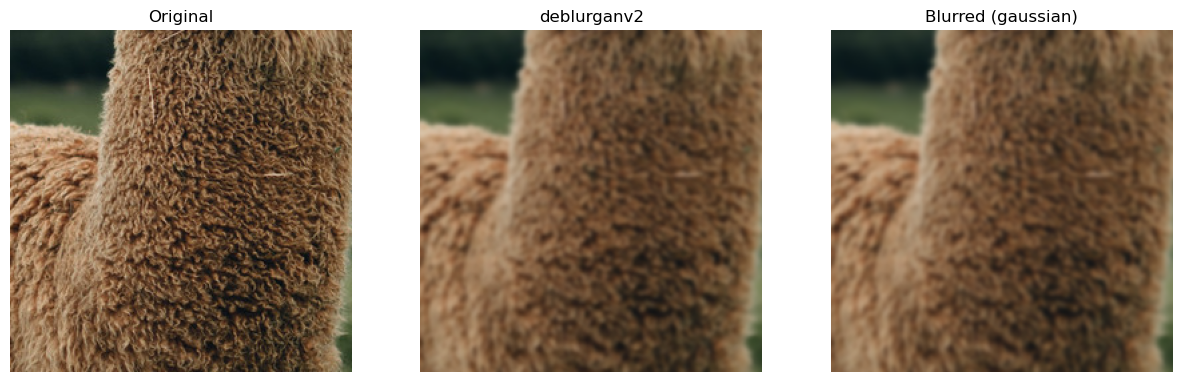

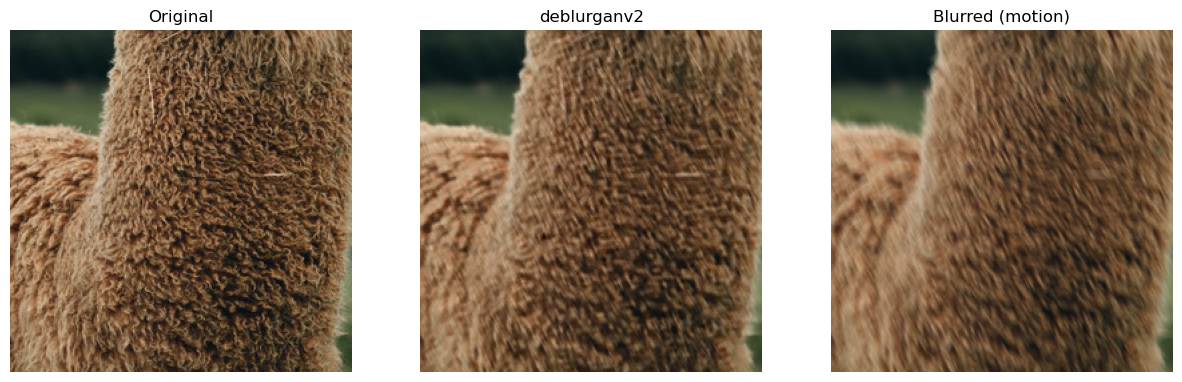

In [5]:
from common.deblurrers import DeblurGANv2Deblurrer
from common.config import OFFICIAL_DEBLURGANV2_WEIGHTS, IDPA_DIR

deblurganv2_deblurrer = DeblurGANv2Deblurrer(
    weights_path=OFFICIAL_DEBLURGANV2_WEIGHTS
)
demo_deblur(
    deblurrer=deblurganv2_deblurrer,
    output_path=IDPA_DIR / ".imgs",
    img_name="000000845.png",
)

Deblur: motion  	: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


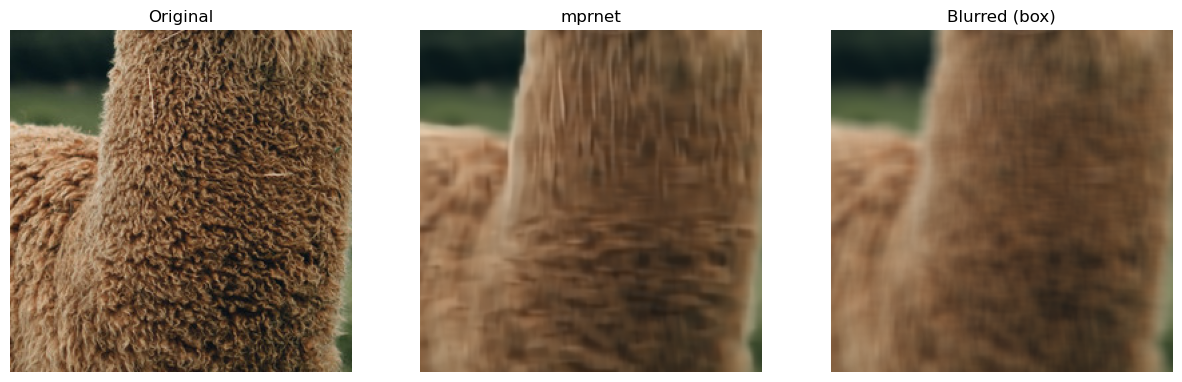

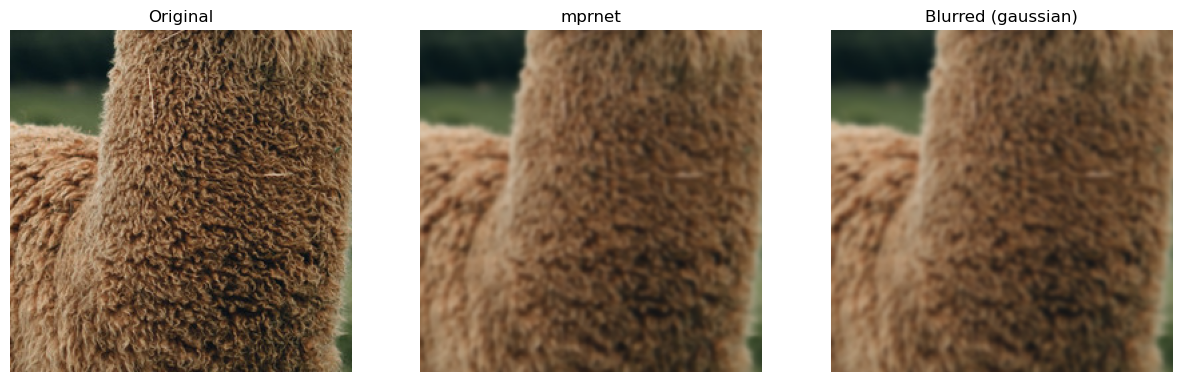

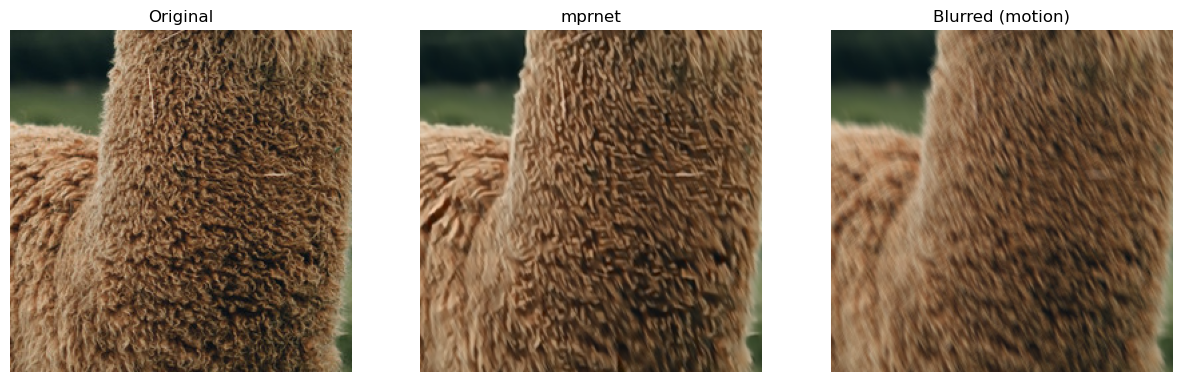

In [6]:
from common.deblurrers import MPRNetDeblurrer
from common.config import OFFICIAL_MPRNET_WEIGHTS, IDPA_DIR

mprnet_deblurrer = MPRNetDeblurrer(
    weights_path=OFFICIAL_MPRNET_WEIGHTS
)
demo_deblur(
    deblurrer=mprnet_deblurrer,
    output_path=IDPA_DIR / ".imgs",
    img_name="000000845.png",
)